# Montreal Bike Share (Bixi) Data Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
import math
from ECDF import ecdf
from IPython.display import HTML
%matplotlib inline 

In [158]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Introduction

I needed to do a project involving data. I also got to practice using github. Everyone I spoke to said to find a data set that I find interesting, and do something with it. The only trouble was, I struggled to find something.

Finally, I came upon the Bixi data. Bixi is the bike-share system in Montreal, and they have data from all the bike rides people take up online for anyone to see and use. As I am interested in alternative transportation in urban areas, and as I used to live in Montreal, this was perfect.

I first imported all the libraries I need.

Then I imported the data I was using. The data are from https://www.bixi.com/en/open-data. 

In [4]:
bixi=pd.read_csv('OD_2018-07.csv')

stations=pd.read_csv('Stations_2018.csv')

Let's see what the data looks like.

In [5]:
print(bixi.head())

         start_date  start_station_code          end_date  end_station_code  \
0  2018-07-01 00:00                6100  2018-07-01 00:20              7068   
1  2018-07-01 00:00                6236  2018-07-01 00:03              6170   
2  2018-07-01 00:00                6100  2018-07-01 00:20              7068   
3  2018-07-01 00:00                6234  2018-07-01 00:15              6905   
4  2018-07-01 00:00                6213  2018-07-01 00:12              6206   

   duration_sec  is_member  
0          1244          0  
1           234          1  
2          1218          0  
3           949          1  
4           739          1  


In [4]:
print(stations.head())

   code                                   name   latitude  longitude
0  7030               de Bordeaux / Marie-Anne  45.533409 -73.570657
1  6141                   de Bordeaux / Rachel  45.532270 -73.568280
2  6100                Mackay / de Maisonneuve  45.496590 -73.578510
3  6064  Métro Peel (de Maisonneuve / Stanley)  45.500380 -73.575070
4  6730                  35e avenue / Beaubien  45.570081 -73.573047


To simplify my analysis, I merged both data sets together, so that the start and end longitude and latitude are included in the bixi dataframe.

In [6]:
bixi=bixi.merge(stations, how='inner', left_on='start_station_code', 
                                right_on='code', left_index=True, sort=False)

bixi= bixi.rename(columns={'latitude': 'start_latitude','longitude':'start_longitude'})

bixi=bixi.drop(labels='code', axis=1)

bixi=bixi.merge(stations, how='inner', left_on='end_station_code', 
                                right_on='code', left_index=True, suffixes=('_start', '_end'), sort=False)

bixi= bixi.rename(columns={'latitude': 'end_latitude','longitude':'end_longitude'})


bixi=bixi.drop(labels='code', axis=1)

bixi['start_date']=pd.to_datetime(bixi['start_date'])

Now that the data are formatted, it's time to attempt to answer some question. Looking at the data there were a few questions that came to mind. 
Do members and non-members use the bikes differently? If they do, how?
Are Bixi bikes usage patterns different on weekdays and weekends? Do people bike faster on weekdays? Are Bixis used for commuting?

## Member vs. Non-Member Usage

To see the difference, I seperated the members and non-members into seperate dataframes.

In [7]:
member=bixi[bixi['is_member']==1]

non_member=bixi[bixi['is_member']==0]

### Duration of Rides

The first attribute I looked at was duration of bike rides. Is there a difference in how long members and non-members ride? To get an overall sense, I looked at the descriptive statistics.

For members:

In [8]:
print(member['duration_sec'].describe())

count    771156.000000
mean        751.099121
std         543.414724
min          61.000000
25%         355.000000
50%         606.000000
75%        1004.000000
max        7192.000000
Name: duration_sec, dtype: float64


For non-members:

In [9]:
print(non_member['duration_sec'].describe())

count    181878.000000
mean       1192.638126
std         796.711194
min          61.000000
25%         678.000000
50%        1053.000000
75%        1492.000000
max        7198.000000
Name: duration_sec, dtype: float64


Members rides outnumber non-member rides by over 4:1. This is expected, as a membership allows you unlimited trips at no additional cost.

From these statistics, a clear difference in bike usage emerges between members and non-members: trips taken by members tend to be shorter than those taken by non-members. The average trip duration for a member is 12.5 minutes (751 seconds) and for non-members it is 19.9 minutes (1193 seconds). Looking at the 25th, 50th, and 75th percentiles for duration, non-members again clearly take longer rides. 

To get a better sense of the data, I plotted the ECDF of both non-member durations and member durations. 


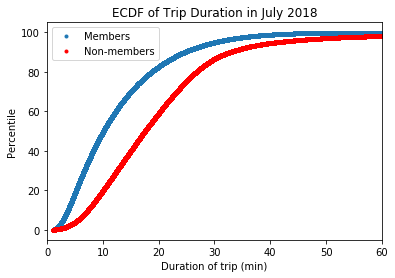

In [10]:
#ECDF out of the duration data of member and non-member trip. ECDF function is written in a different file.
x1,y1=ecdf(member['duration_sec'][member['duration_sec']>0])
x2,y2=ecdf(non_member['duration_sec'][non_member['duration_sec']>0])


_ = plt.plot(x1/60, y1 * 100, marker='.', linestyle='None')
_ = plt.plot(x2/60, y2 * 100, marker='.', linestyle='None', color='red')
_ = plt.xlabel('Duration of trip (min)')
_ = plt.ylabel('Percentile')
_ = plt.xlim((0,60))
_ = plt.title('ECDF of Trip Duration in July 2018')
_ = plt.legend(['Members', 'Non-members'])

plt.show()

The non-member graph is flatter at the beginning, and then becomes steeper. This makes sense: very few people would pay to use a bixi if they only plan on riding for less than five minutes. It isn’t worth it. On the other hands, it doesn’t cost members anything extra, so extremely short trips are worth it to them. 

Looking at the graph, it is also apparent, by the more gradual leveling off of the graph, that a higher percentage of non-members use bixis for very long periods of time. A possible explanation for this is that non-members are more likely to be tourists who are touring the city on a bike, instead of trying to get from one point to another.

Looking at the ECDF prompted another question: if trips under 5 minutes long were not included, would the ECDF of members and non-members be the same? Put another way: other than the trips that are too short to be worth it for non-members, do bikes get used for similar durations? The answer is no, the non-member still generally take longer trips by duration.

### Ride Start Location

So non-members tend to go on longer rides. 

What about where they start their trips? Do non-members have a tendency to start their trips in a different place than members?

To explore this question, I looked at how many times member and non-member trips started at each Bixi station. I created new dataframes to do this.

In [11]:
member_start= member['start_station_code'].value_counts()
non_member_start= non_member['end_station_code'].value_counts()


member_start.apply(pd.Series)
non_member_start.apply(pd.Series)

member_start.columns=['start_station_code','counts']
non_member_start.columns=['end_station_code','counts']

member_start=pd.DataFrame(member_start)
non_member_start=pd.DataFrame(non_member_start)

member_start=member_start.sort_index()
non_member_start=non_member_start.sort_index()

member_start.columns=['counts']
non_member_start.columns=['counts']

stations_temp=stations
stations_temp=stations_temp.set_index('code')
stations_temp=stations_temp.sort_index()

member_start=member_start.merge(stations_temp, how='outer', left_index=True, right_index=True)
non_member_start=non_member_start.merge(stations_temp, how='outer', left_index=True, right_index=True)

I then mapped these, with the x and y axes being longitude and latittude, and the frequency of use being the size of the markers.

The member marker sizes are scaled so that they represent the proportion of members starting at that station.
The non-member marker sizes are scaled so that they represent the proportion of non-members starting at that station.

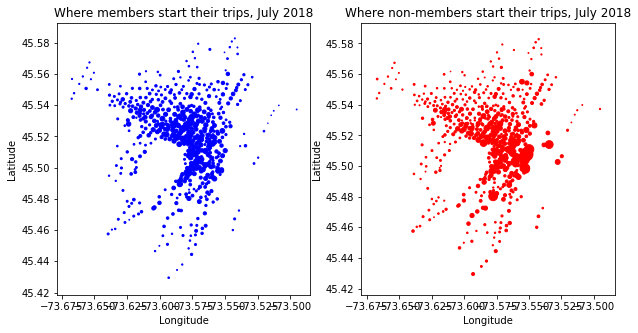

In [156]:
#map members and non-member trips seperately
_ = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_ = plt.scatter(x=member_start['longitude'], y=member_start['latitude'], 
                s=member_start['counts']/member_start['counts'].sum()*5000, alpha=1, color='blue')
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Where members start their trips, July 2018')


plt.subplot(1,2,2)
_ = plt.scatter(x=non_member_start['longitude'], y=non_member_start['latitude'], 
                s=non_member_start['counts']/non_member_start['counts'].sum()*5000, alpha=1, color='red')
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Where non-members start their trips, July 2018')

plt.show()

Proportionally, it looks like non-members have a greater concentration of trips starting from around Old Port, which is a very touristy area. Otherwise, the graphs look similar.

I then made another graph, subtracting the two graphs above, to find which areas are unproportionally more popular with members and which are unproportionally more popular with non-members.

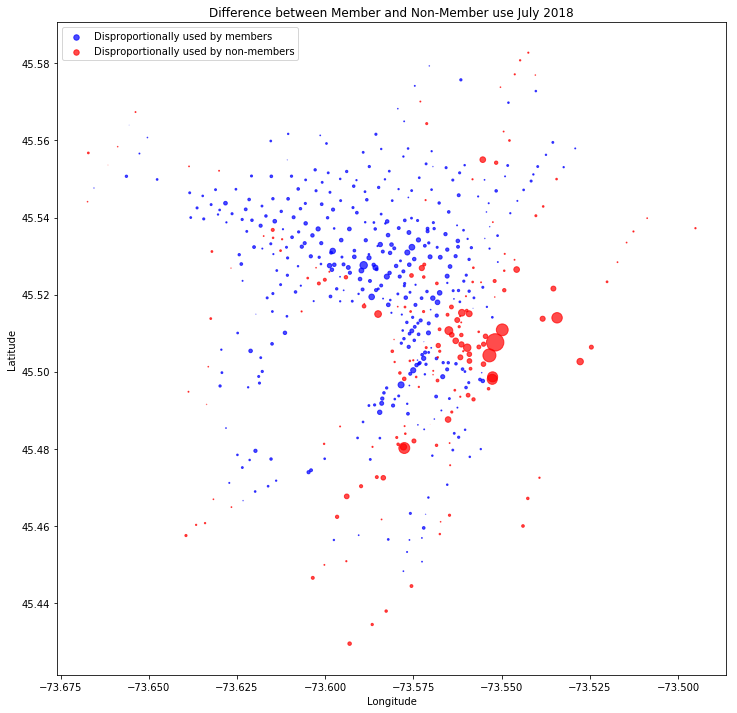

In [74]:
#This plots the difference between proportion of member rides over total member rides and proportion of non-member rides over non-member total
Difference=member_start['counts']/(member_start['counts'].sum())- non_member_start['counts']/(non_member_start['counts'].sum())
member_start['Difference']=Difference

_ = plt.figure(figsize=(12,12))

_ = plt.scatter(x=(member_start['longitude'][member_start['Difference']>=0]),
                y=member_start['latitude'][member_start['Difference']>=0],  
                s=abs(Difference[member_start['Difference']>=0])*10000, alpha=0.7, color='blue')
_ = plt.scatter(x=(member_start['longitude'][member_start['Difference']<0]), 
                y=member_start['latitude'][member_start['Difference']<0],  
                s=abs(Difference[member_start['Difference']<0])*10000, alpha=0.7, color='red')

_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Difference between Member and Non-Member use July 2018')

lgnd = plt.legend(['Disproportionally used by members', 'Disproportionally used by non-members'])
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

_ = plt.savefig('Bixi_Station_Start_members_and_non_members_difference', dpi=600)

plt.show()

From this graph, the observation that non-members like Old Port can be seen a lot more clearly.  A plausible explanation for this is that non-members are often tourists, and Old Port is a very touristy area of Montreal.

## Weekday vs. Weekend

I was curious: do trips by bike always take, on average, the same amount of time for the distance traveled? Or are there times of the day where travel is slower or faster?

To answer this question, I first needed to calculate the distance traveled, which I used a function for. The distance calculated is 'as the crow flies'. This would not be a valid method if I wanted to know the precise average speed at every hour of the day. But, since the purpose of this analysis is a comparison between hours, this is valid.

An assumption that I made is that the start and end of rides do not change significantly over time. Therefore, the distance calculated can be considered as comparing like with like.


I first found the distance traveled.

In [12]:
from Distance import haversine as distance

In [76]:
bixi['distance_traveled']=0
bixi['distance_traveled']=distance(bixi['start_latitude'],bixi['start_longitude'],
                                           bixi['end_latitude'],bixi['end_longitude'])

In [79]:
bixi_hourly=bixi
bixi_hourly['number_of_trips']=1

In [82]:
bixi_hourly=bixi_hourly.set_index('start_date')

            start_station_code          end_date  end_station_code  \
start_date                                                           
2018-07-01                6100  2018-07-01 00:20              7068   

            duration_sec  is_member               name_start  start_latitude  \
start_date                                                                     
2018-07-01          1244          0  Mackay / de Maisonneuve        45.49659   

            start_longitude  code          name_end  end_latitude  \
start_date                                                          
2018-07-01        -73.57851  7068  Basin / Richmond     45.487601   

            end_longitude  distance_traveled  number_of_trips  
start_date                                                     
2018-07-01     -73.565185           1.441454                1  


Then I resampled by the hour, taking the mean duration and distance traveled for every hour, as well as the sum of all the trips and members.

In [84]:
#bixi_hourly=bixi.drop(columns['start_station'])
bixi_hourly=bixi_hourly.resample('1H', how={'duration_sec': np.mean, 'distance_traveled': np.mean, 'is_member':np.sum, 'number_of_trips':np.sum})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


I found the fraction of rides every hour that were by members. The data was in an easy format to do this, and I thought maybe it would add something to the conclusions from the last section.

In [87]:
bixi_hourly['fraction_members']=bixi_hourly['is_member']/bixi_hourly['number_of_trips']

From here, I created two data sets: a weekday one, and a weekend one. Each one has 24 entries, each representing an hour. 



In [108]:
bixi_hourly['day_of_the_week']=bixi_hourly.index.weekday

weekend=(bixi_hourly['day_of_the_week']==5) | (bixi_hourly['day_of_the_week']==6)
weekend=bixi_hourly[weekend]

weekday=(bixi_hourly['day_of_the_week']==0) | (bixi_hourly['day_of_the_week']==1) | \
(bixi_hourly['day_of_the_week']==2) | (bixi_hourly['day_of_the_week']==3) | (bixi_hourly['day_of_the_week']==4) 
weekday=bixi_hourly[weekday]

In [115]:
weekday= weekday.groupby([weekday.index.hour]).mean()
weekend= weekend.groupby([weekday.index.hour]).mean()

AttributeError: 'Int64Index' object has no attribute 'hour'

In [119]:
weekday=weekday.drop(columns=['day_of_the_week'])
weekend=weekend.drop(columns=['day_of_the_week'])

First, I plotted the time of the day against the speed of the trips for both weekends and weekdays. The speed was calculated by dividing distance traveled by the duration of the trip.

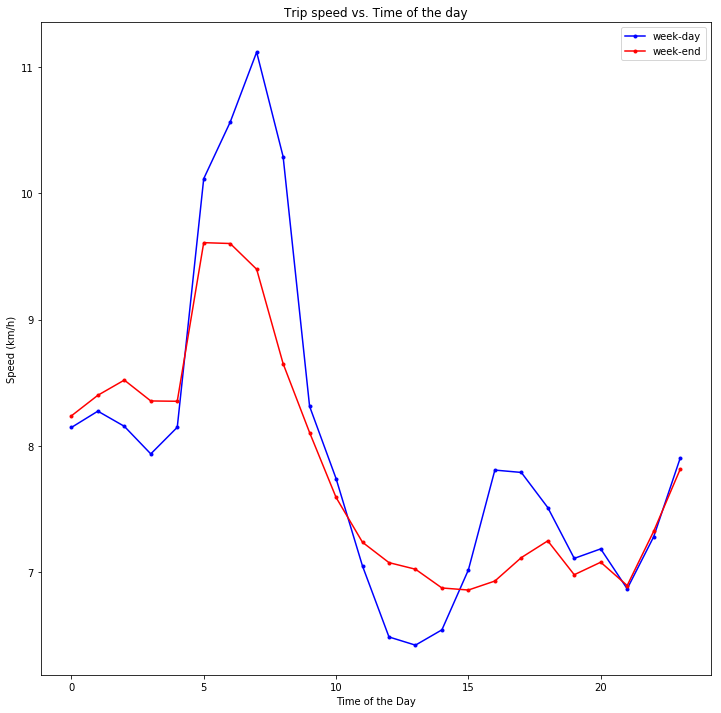

In [161]:
_ = plt.figure(figsize=(12,12))

_ = plt.plot(weekday.index,
                weekday['distance_traveled']/weekend['duration_sec']*3600, marker='.', color='blue')
_ = plt.plot(weekend.index,
                weekend['distance_traveled']/weekend['duration_sec']*3600, marker='.', color='red')

#_ = plt.xlim('2018-07-02 04:00','2018-07-02 22:00')
_ = plt.xlabel('Time of the Day')
_ = plt.ylabel('Speed (km/h)')
_ = plt.title('Trip speed vs. Time of the day')
lgnd = plt.legend(['week-day','week-end'])

plt.show()

Do people bike faster to work, or coming home in the evening? The data show that people bike faster on their morning commute. This makes sense intuitively: people are often in a rush to get to work on time, but getting home does not have the same pressure. 

Another intuition that is borne out by data: people are in less of a rush on weekends. From 10:00 to 20:00, the average speed is pretty constant. The early morning peak can also be explained: many people up at 06:00 on a weekend work on weekends. The peak is less pronounced than on weekdays though. Maybe some poor souls' idea of a pleasant weekend morning is a leisurely bike ride at 6 am?

I plotted the percentage of riders that are members at each hour of the day on weekend and weekdays.

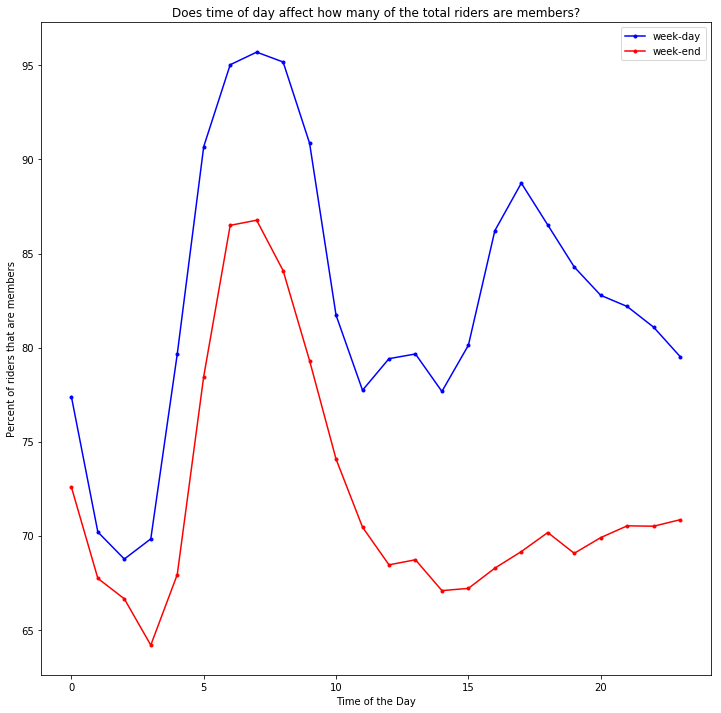

In [152]:
_ = plt.figure(figsize=(12,12))

_ = plt.plot(weekday.index,
                weekday['fraction_members']*100, 
                marker='.', color='blue')
_ = plt.plot(weekend.index,
                weekend['fraction_members']*100, 
                marker='.', color='red')

_ = plt.legend(['week-day','week-end'])
_ = plt.xlabel('Time of the Day')
_ = plt.ylabel('Percent of riders that are members')
_ = plt.title('Does time of day affect how many of the total riders are members?')

plt.show()

Again, many of the takeaways from this plot are intuitive. 

The percent of riders that are members is higher on weekdays than weekends. The out-of-towners and local looking to enjoy biking the city bring down the percentage of members on weekends.

The percent of members peak during the morning commuting hours, surpassing 95% on weekdays. Again, this makes sense. How many people roll out of bed at 6 am on a Monday and spontaneously decide that now is a good time to ride a bixi?

From the plot above and the plot before it, I can safely say that people biking around between the hours of 6 and 8 am mean business. They bike faster and are serious about their bixi use (they are members).

Lastly, I plotted the average number of trips made each hour on weekdays and weekends.

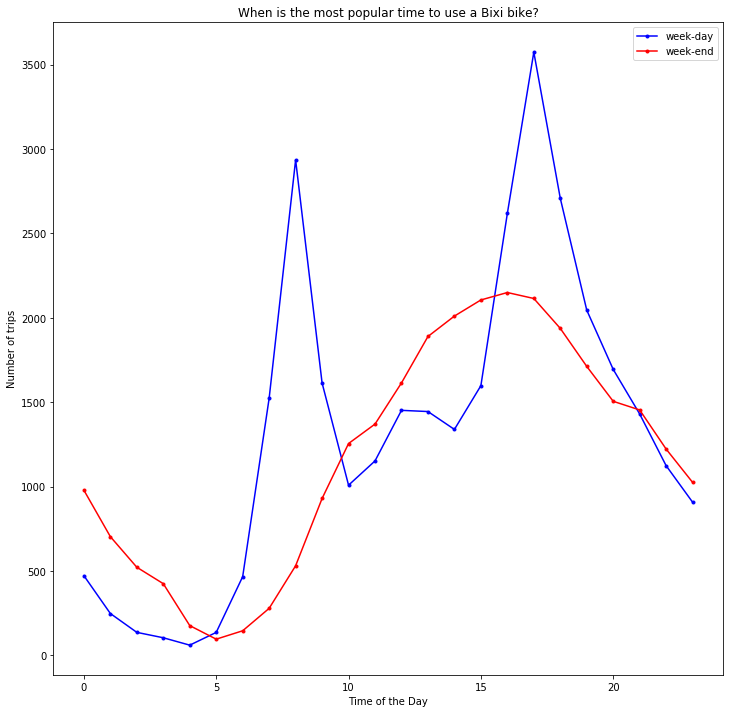

In [153]:
_ = plt.figure(figsize=(12,12))

_ = plt.plot(weekday.index,
                weekday['number_of_trips'], 
                marker='.', color='blue')
_ = plt.plot(weekend.index,
                weekend['number_of_trips'], 
                marker='.', color='red')

#_ = plt.xlim('2018-07-02 04:00','2018-07-02 22:00')
_ = plt.xlabel('Time of the Day')
_ = plt.ylabel('Number of trips')
_ = plt.title('When is the most popular time to use a Bixi bike?')
_ = plt.legend(['week-day','week-end'])

plt.show()

More intuition is borne out by data. 

People are more likely to drunkenly bike home after a night out on weekends than on a weekday. 

Weekdays have very pronounced peaks during commuting hours, as expected. This strongly suggests that Bixis are used a lot for commuting.
Weekends peak between 15:00 and 17:00, when people are out enjoying the late afternoon sun.

# Conclusion

I was not able to tease out any insights out of the public Bixi data that were unexpected. Still, it's nice to be able to back up expected results with data.